In [1]:
#!pip install --upgrade qiskit

In [1]:
#%matplotlib inline
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Qiskit Summer School Final Project: VQE

## Some defintions

In [3]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    #ee = ExactEigensolver(qubitOp)
    ee = NumPyEigensolver(qubitOp)
    result = ee.run()
    ref = result['eigenvalues']
    #print('Reference value: {}'.format(ref))
    return ref

In [4]:
backend = BasicAer.get_backend('statevector_simulator')

In [5]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)

In [6]:
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    #freeze_list = [0,6] 
    #remove_list = [3,8]
    print("remove_list=",remove_list)
    print("freeze_list=",freeze_list)

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp #that is: if map_type == 'parity' do two_qibit_reduction, else do nothing 
    qubitOp.chop(10**-10)
    total_en_shift = energy_shift + nuclear_repulsion_energy

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift

### Define some paramters and compute qubit operator

In [7]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(map_type,inter_dist)

HF energy: -8.921712043375118
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]


### Define reference energy

In [8]:
ref = exact_solver(qubitOp)

print("ref. energy=",np.round(np.real(ref[0]),4))
print("total_en_shift",np.round(total_en_shift,4))
exact_energy = np.real(ref[0] + total_en_shift)
print("exact energy=",np.round(exact_energy,4))

ref. energy= -1.0991
total_en_shift -6.782
exact energy= -7.881


In [9]:
backend = BasicAer.get_backend("statevector_simulator")

for maxter in [5,10]:
    optimizer = SLSQP(maxiter=maxter)

    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping=map_type
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping=map_type
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
    print("Max iter.:",maxter,"VQE Result:", vqe_result, "Exact Energy:", exact_energy)

Max iter.: 5 VQE Result: -7.88097950128812 Exact Energy: -7.881015715646995
Max iter.: 10 VQE Result: -7.881015701737771 Exact Energy: -7.881015715646995


In [10]:
optimizer = SLSQP(maxiter=10)

initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping=map_type
) 
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping=map_type
)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
vqe_result_SLSQP = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result SLSQP:", np.round(vqe_result_SLSQP,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result SLSQP: -7.88102 Exact Energy: -7.88102


In [11]:
counts_SLSQP = counts
en_diff_SLSQP = values - np.real(ref[0])
dev_SLSQP = deviation

In [12]:
optimizer = SPSA(max_trials=200)

counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
vqe_result_SPSA = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result SPSA:", np.round(vqe_result_SPSA,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result SPSA: -7.74756 Exact Energy: -7.88102


In [13]:
counts_SPSA = counts
en_diff_SPSA = values - np.real(ref[0])
deviation_SPSA = deviation

In [14]:
optimizer = COBYLA(maxiter=200, tol=0.001)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
vqe_result_COBYLA = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result COBYLA:", np.round(vqe_result_COBYLA,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result COBYLA: -7.88101 Exact Energy: -7.88102


In [15]:
counts_COBYLA = counts
en_diff_COBYLA = values - np.real(ref[0])
deviation_COBYLA = deviation

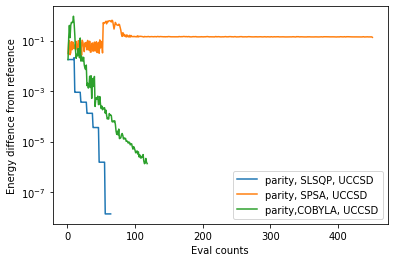

In [16]:
plt.plot(counts_SLSQP,en_diff_SLSQP,label="parity, SLSQP, UCCSD")
plt.plot(counts_SPSA,en_diff_SPSA,label="parity, SPSA, UCCSD")
plt.plot(counts_COBYLA,en_diff_COBYLA,label="parity,COBYLA, UCCSD")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

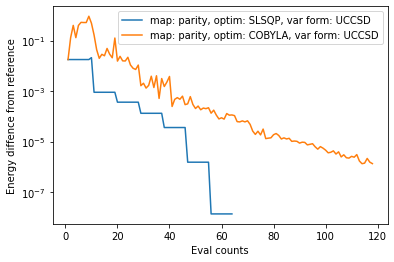

In [17]:
plt.plot(counts_SLSQP,en_diff_SLSQP,label="map: parity, optim: SLSQP, var form: UCCSD")
plt.plot(counts_COBYLA,en_diff_COBYLA,label="map: parity, optim: COBYLA, var form: UCCSD")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

In [18]:
print("VQE Result SLSQP:", np.round(vqe_result_SLSQP,5), "Exact Energy:", np.round(exact_energy,5))
print("VQE Result SPSA:", np.round(vqe_result_SPSA,5), "Exact Energy:", np.round(exact_energy,5))
print("VQE Result COBYLA:", np.round(vqe_result_COBYLA,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result SLSQP: -7.88102 Exact Energy: -7.88102
VQE Result SPSA: -7.74756 Exact Energy: -7.88102
VQE Result COBYLA: -7.88101 Exact Energy: -7.88102


### Now I change the variational form 

I try with RY variational form, and I choose COBYLA as optimizer

In [19]:
depth = 2
num_qubits=qubitOp.num_qubits
RY_var_form = RY(num_qubits, depth=depth)

In [20]:
var_form=RY_var_form
optimizer = COBYLA(maxiter=100, tol=0.001)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
result_RY = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result var form RY:", np.round(result_RY,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result var form RY: -7.86161 Exact Energy: -7.88102


In [21]:
var_form=RY_var_form
optimizer = COBYLA(maxiter=800, tol=0.001)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
result_RY = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result var form RY:", np.round(result_RY,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result var form RY: -7.87685 Exact Energy: -7.88102


In [22]:
counts_RY_COBYLA = counts
en_diff_RY_COBYLA = values - np.real(ref[0])
deviation_RY_COBYLA = deviation

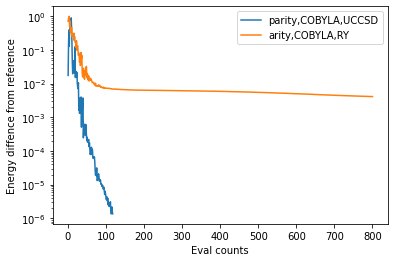

In [23]:
plt.plot(counts_COBYLA,en_diff_COBYLA,label="parity,COBYLA,UCCSD")
plt.plot(counts_RY_COBYLA,en_diff_RY_COBYLA,label="arity,COBYLA,RY")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

### I compare with different depths

depth: 1 VQE Result var. form RY from ref: 0.0177
depth: 2 VQE Result var. form RY from ref: 0.01247
depth: 3 VQE Result var. form RY from ref: 0.0018
depth: 4 VQE Result var. form RY from ref: 0.00631
depth: 5 VQE Result var. form RY from ref: 0.03941


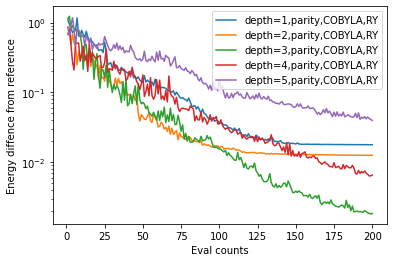

In [24]:
for depth in [1,2,3,4,5]:
    num_qubits = qubitOp.num_qubits
    var_form = RY(num_qubits, depth=depth)
    optimizer = COBYLA(maxiter=200, tol=0.001)
    counts=[]
    values=[]
    params=[]
    deviation=[]
    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    result_RY = np.real(vqe.run(backend)['eigenvalue'] - ref[0])
    print("depth:", depth,"VQE Result var. form RY from ref:", np.round(result_RY,5))
    counts_RY_COBYLA = counts
    en_diff_RY_COBYLA = values - np.real(ref[0])
    plt.plot(counts_RY_COBYLA,en_diff_RY_COBYLA,label="depth="+str(depth)+",parity,COBYLA,RY")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

### Now I try with noise

In [25]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'

device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map

#basis_gates = noise_model.basis_gates

noise_model = NoiseModel.from_backend(device.properties())
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'id', 'measure', 'cx', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [26]:
simulator = Aer.get_backend('qasm_simulator')

In [27]:
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [28]:
quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

In [29]:
num_qubits = qubitOp.num_qubits
var_form = RY(num_qubits, depth=depth)
#optimizer = COBYLA(maxiter=200, tol=0.001)
optimizer = SPSA(max_trials=100)
#var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer=optimizer,callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'] -ref[0])

In [30]:
print("VQE Result var. form RY from ref with noise:", vqe_result)

VQE Result var. form RY from ref with noise: 0.3162457962534845


In [31]:
counts_noise_SPSA_RY = counts
en_diff_noise_SPSA_RY = values - np.real(ref[0])
deviation_noise_SPSA_RY = deviation

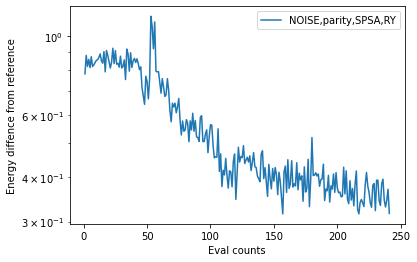

In [34]:
plt.plot(counts_noise_SPSA_RY,en_diff_noise_SPSA_RY,label="NOISE,parity,SPSA,RY")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()